This notebook uses an RBF (Radial Basis Function) model to predict traffic congestion based on video analysis.

**1. Setup and Data Loading**

Installs the ultralytics library using pip install ultralytics.
Uploads a video file named traffic.mov.
Imports necessary libraries: cv2, numpy, ultralytics, google.colab.patches.

**2. Video Processing and Feature Extraction**

Loads the video using cv2.VideoCapture.
Initializes a YOLOv8 model for object detection: model = YOLO("yolov8n.pt").
Defines vehicle classes to detect (car, motorcycle, bus, truck).
Iterates through video frames, detecting vehicles using the YOLO model.
Calculates vehicle count, average speed, and congestion level for each frame.
Stores this traffic data in a NumPy array.

**3. RBF Model Training and Evaluation**

Imports necessary libraries for RBF modeling: sklearn.svm, sklearn.preprocessing, sklearn.model_selection.
Normalizes the traffic data using MinMaxScaler.
Splits the data into training and testing sets using train_test_split.
Creates and trains an RBF model using SVR with an RBF kernel.
Evaluates the model's performance using Mean Squared Error (MSE) and R² Score.

**4. Visualization**

Imports matplotlib.pyplot and seaborn for visualization.
Plots graphs showing:
Vehicle count over time
Average speed over time
Congestion level over time
Predicted vs. actual congestion level
In summary, the notebook analyzes a traffic video to extract features (vehicle count, speed, congestion). It then trains an RBF model to predict congestion levels based on these features and evaluates the model's performance. Finally, it visualizes the traffic data and predictions using graphs.



First we have to install the required libraries. For that run the cell below after connecting with the T4 GPU.



In [1]:
!pip install ultralytics

^C


  Using cached ultralytics-8.3.120-py3-none-any.whl.metadata (37 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
  Using cached torch-2.7.0-cp313-cp313-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached ultralytics-8.3.120-py3-none-any.whl (1.0 MB)
Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl (156 kB)
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? 

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\lenovo\\AppData\\Local\\Temp\\pip-unpack-r939wygn\\torch-2.7.0-cp313-cp313-win_amd64.whl'
Consider using the `--user` option or check the permissions.



create the content named folder in the same directory as this file is located. Then run the cell below, it will upload the video to that content folder, strictly you have to name it as traffic.mov

In [17]:
# from google.colab import files
# uploaded = files.upload()

You can check if the video is uploaded or not by running the cell below.

In [16]:
# import os
# print(os.listdir("/content"))


Now running the cell below will give the input for the actual training process, it will analyze the video frame by frame and get the data in matrix form for the input for training process. it is with few steps for easy breakdown of what is happening.

first importing the required libraries.

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
# from google.colab.patches import cv2_imshow

print("all libraries loaded")

all libraries loaded


Path verification.

In [4]:
video_path = "content/traffic.mov"

if not os.path.exists(video_path):
    raise FileNotFoundError(f" Error: Video file '{video_path}' not found. Please upload it.")

print(f" Video file '{video_path}' found.")

 Video file 'content/traffic.mov' found.


loading the video.

In [5]:
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(" Error: Could not open video. Check the file format and try again.")

print("🎥 Video loaded successfully.")

🎥 Video loaded successfully.


here we are going to use YOLO model for the object detection as it uses uses a single convolutional neural network (CNN) to predict bounding boxes and class probabilities for objects in an image.

In [6]:
model = YOLO("yolov8n.pt")
print(" Model loaded successfully.")

100%|██████████| 6.25M/6.25M [00:04<00:00, 1.53MB/s]

 Model loaded successfully.


Vehicle class are defined in here.

In [7]:
VEHICLE_CLASSES = [2, 3, 5, 7]  # Car, Motorcycle, Bus, Truck

frame_rate = int(cap.get(cv2.CAP_PROP_FPS) or 30)
road_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 640)

prev_positions = {}
traffic_data = []
print ("Stored collected traffic data")

Stored collected traffic data


Video frames are processed.

In [8]:

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(" End of video.")
        break

    results = model(frame)  # Run YOLO inference
    new_positions = {}
    vehicle_count = 0

    for result in results:  # Iterate over YOLO detections
        if result.boxes is None:
            continue  # Skip if no detections

        for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
            x1, y1, x2, y2 = box  # Get bounding box
            class_id = int(cls)  # Class label

            if class_id in VEHICLE_CLASSES:  # Check if it's a vehicle
                vehicle_count += 1
                center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
                new_positions[class_id] = (center_x, center_y)

                # Draw Bounding Boxes & Labels
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(frame, f"Vehicle {class_id} ({conf:.2f})", (int(x1), int(y1) - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    speed_data = []
    for class_id, (x, y) in new_positions.items():
        if class_id in prev_positions:
            distance = np.sqrt((x - prev_positions[class_id][0])**2 + (y - prev_positions[class_id][1])**2)
            speed = (distance * frame_rate) / 10  # Approximate speed calculation
            speed_data.append(speed)

    avg_speed = np.mean(speed_data) if speed_data else 0
    congestion_level = vehicle_count / max(road_width, 1)  # Prevent division by zero
    #  Store Traffic Data
    traffic_data.append([vehicle_count, avg_speed, congestion_level])

    #  Display Metrics on Frame
    cv2.putText(frame, f"Vehicles: {vehicle_count}", (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f"Speed: {avg_speed:.2f} km/h", (20, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"Congestion: {congestion_level:.2f}", (20, 130),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Show Frame
    # cv2_imshow(frame)

    prev_positions = new_positions

cap.release()


0: 416x640 3 cars, 245.1ms
Speed: 15.8ms preprocess, 245.1ms inference, 17.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 123.2ms
Speed: 3.2ms preprocess, 123.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 82.2ms
Speed: 3.5ms preprocess, 82.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 75.9ms
Speed: 2.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



C:\Users\lenovo\AppData\Local\Temp\ipykernel_46144\3282880425.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  distance = np.sqrt((x - prev_positions[class_id][0])**2 + (y - prev_positions[class_id][1])**2)


0: 416x640 3 cars, 1 truck, 88.4ms
Speed: 1.9ms preprocess, 88.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 1 truck, 95.8ms
Speed: 3.0ms preprocess, 95.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 87.5ms
Speed: 3.3ms preprocess, 87.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 74.1ms
Speed: 1.7ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 76.3ms
Speed: 1.7ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 92.3ms
Speed: 1.8ms preprocess, 92.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 81.5ms
Speed: 1.6ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 73.0ms
Speed: 2.7ms preprocess, 73.0ms inference, 0.9ms postprocess per image at shape (1, 3, 4

conversion of Traffic data into array.

In [10]:
traffic_data = np.array(traffic_data)
print("Final Traffic Data:\n", traffic_data)



Final Traffic Data:
 [[          3           0   0.0032258]
 [          3    0.022887   0.0032258]
 [          3      7.4772   0.0032258]
 ...
 [          0           0           0]
 [          0           0           0]
 [          0           0           0]]


Radial Basis Function (RBF) Model
Using Scikit-Learn's RBF kernel for regression:

In [11]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize Data
scaler = MinMaxScaler()
X = scaler.fit_transform(traffic_data[:, :-1])  # Features
y = scaler.fit_transform(traffic_data[:, -1].reshape(-1, 1))  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RBF Model
rbf_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
rbf_model.fit(X_train, y_train.ravel())

# Predictions
y_pred = rbf_model.predict(X_test)

print("continue")

continue


Performance Evaluation
Evaluate the model using metrics like Mean Squared Error (MSE) and R² Score:

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Performance:\nMSE: {mse:.4f}, R² Score: {r2:.4f}")


📊 Model Performance:
MSE: 0.0019, R² Score: 0.9443


now visualizing the result.
For visualization, let's use Matplotlib and Seaborn to analyze traffic trends. plotting:

Vehicle Count Over Time

Average Speed Over Time

Congestion Level Over Time

Predicted vs. Actual Congestion Level

Scaler error: X has 2 features, but MinMaxScaler is expecting 1 features as input.


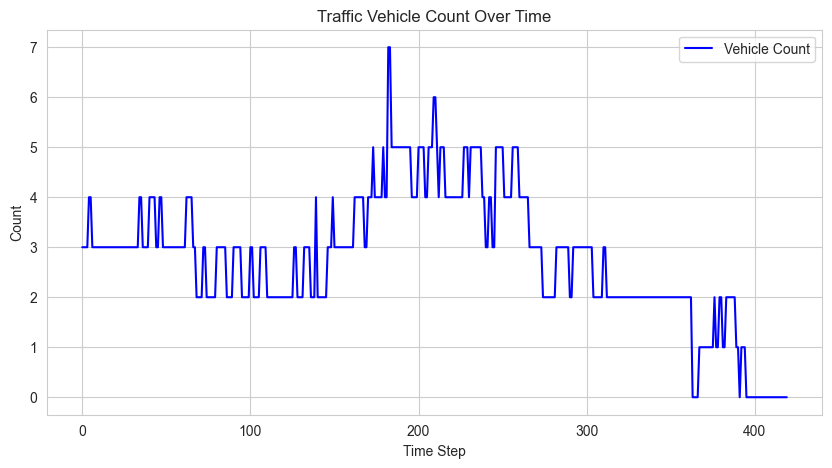

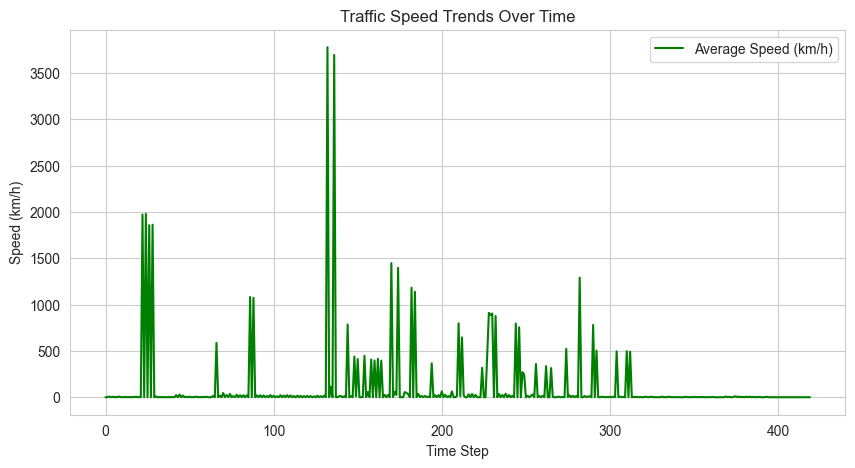

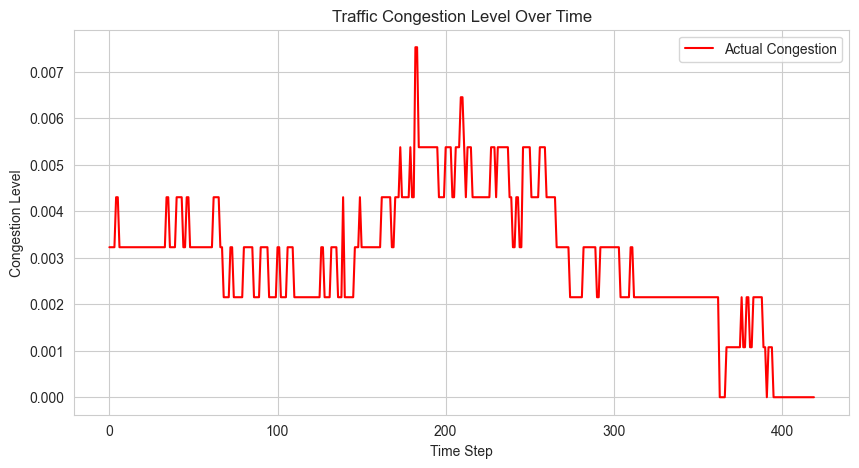

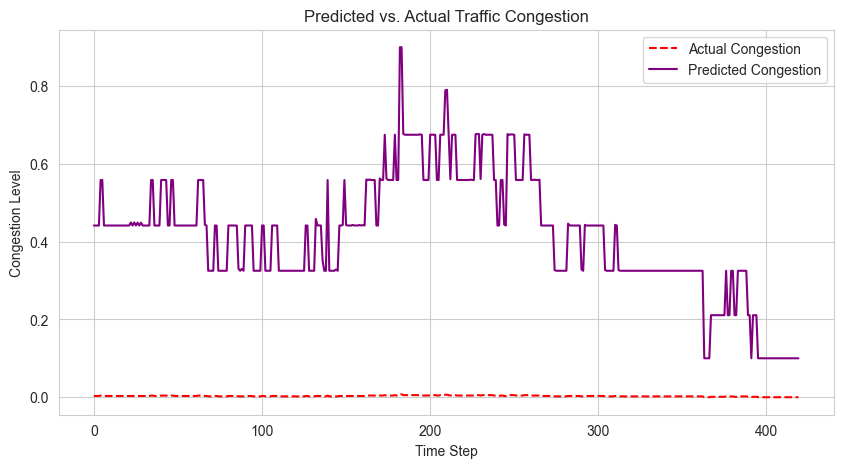

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Generate time indices
time_steps = np.arange(len(traffic_data))

# Extract metrics
vehicle_count = traffic_data[:, 0]
avg_speed = traffic_data[:, 1]
congestion = traffic_data[:, 2]

# Ensure correct shape for scaling
traffic_features = traffic_data[:, :-1]  # Exclude congestion column

# Reshape if necessary
if len(traffic_features.shape) == 1:
    traffic_features = traffic_features.reshape(-1, 1)

# Fit the scaler if not already fitted
try:
    predicted_congestion = rbf_model.predict(scaler.transform(traffic_features))
except ValueError as e:
    print(f"Scaler error: {e}")
    scaler.fit(traffic_features)  # Refit scaler to correct shape
    predicted_congestion = rbf_model.predict(scaler.transform(traffic_features))

# Set seaborn style
sns.set_style("whitegrid")

# Vehicle Count Over Time
plt.figure(figsize=(10, 5))
plt.plot(time_steps, vehicle_count, label="Vehicle Count", color="blue")
plt.xlabel("Time Step")
plt.ylabel("Count")
plt.title("Traffic Vehicle Count Over Time")
plt.legend()
plt.show()

# Average Speed Over Time
plt.figure(figsize=(10, 5))
plt.plot(time_steps, avg_speed, label="Average Speed (km/h)", color="green")
plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.title("Traffic Speed Trends Over Time")
plt.legend()
plt.show()

# Congestion Level Over Time
plt.figure(figsize=(10, 5))
plt.plot(time_steps, congestion, label="Actual Congestion", color="red")
plt.xlabel("Time Step")
plt.ylabel("Congestion Level")
plt.title("Traffic Congestion Level Over Time")
plt.legend()
plt.show()

# Predicted vs. Actual Congestion
plt.figure(figsize=(10, 5))
plt.plot(time_steps, congestion, label="Actual Congestion", color="red", linestyle="dashed")
plt.plot(time_steps, predicted_congestion, label="Predicted Congestion", color="purple")
plt.xlabel("Time Step")
plt.ylabel("Congestion Level")
plt.title("Predicted vs. Actual Traffic Congestion")
plt.legend()
plt.show()


In [15]:
import joblib

# Save model and scaler
joblib.dump(rbf_model, 'rbf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model and scaler saved as .pkl files.")


✅ Model and scaler saved as .pkl files.
